# Descripción del trabajo

En este trabajo se hicieron muchas pruebas distintas, modificando los diferentes hiperparámetros con el objetivo mejorar los modelos anteriores. Lo primero que se hizo fue un data augmentation, rotando las imágenes 180 grados. A continuación se probaron distintas arquitecturas, variando la cantidad de capas y neuronas en las capas densas. Luego se fue intentando encontrar la mejor combinación de hiperparámetros posibles, teniendo en cosideración los siguientes:

* Batch size
* Max norm
* Batch normalization
* Dropout
* Learning rate (inicialización y patience para su reducción en la meseta)
* Early stopping (patience)

No todas las pruebas están presentes en este informe, ya que muchas de ellas no eran más que variantes casi idénticas a una de las que sí están presentes, pero con peores resultados. Tampoco se utilizaron todas las estrategias de regularización al mismo tiempo, sino que se fueron variando para determinar cuales eran más efectivas. En casi todos los casos, se configuró una cantidad de épocas grande, de forma que el entrenamiento termine con el early stopping y no porque las épocas no fueran suficientes. Tal como se menciona más adelante en el informe, los mejores resultados se obtivieron con la denominada prueba 6, que consistió en lo siguiente:

* 4 capas densas ocultas de 1000 neuronas cada una
* Batch normalization en todas sus capas ocultas
* Función de activación: relu
* Learning rate inicial de 10e-3 y reducción a la mitad con paciencia de 8, con un mínimo de 10e-5
* Early stopping con paciencia de 12
* Batch size de 16

La máxima precisión de validación fue de 0.3022, y ese fue el modelo que se subió a la plataforma de Kaggle, logrando una precisión de testeo de 0.3024

# Librerías y Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm, max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

#Importar Base de Datos

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Redes_neuronales"

# Verificar que el archivo kaggle.json está en la ruta correcta
!ls /content/drive/MyDrive/Redes_neuronales

 kaggle.json   TP-MLP.ipynb  'TP Redes Neuronales.gdoc'


In [ ]:
!kaggle competitions download -c dl-itba-cifar-100-2024-q-1

 93% 150M/161M [00:01<00:00, 88.9MB/s]
100% 161M/161M [00:02<00:00, 84.2MB/s]


In [ ]:
# Crear la carpeta de destino si no existe
dataset_dir = "/content/drive/MyDrive/Redes_neuronales"
os.makedirs(dataset_dir, exist_ok=True)

# Mover el archivo descargado a la carpeta de destino
!mv /content/dl-itba-cifar-100-2024-q-1.zip {dataset_dir}

# Cambiar el directorio a la carpeta de destino
%cd {dataset_dir}

/content/drive/.shortcut-targets-by-id/1EPc8z0jZeJpV_WAyZo4DrycNEomiMzQK/Redes_neuronales
unzip:  cannot find or open /content/dl-itba-cifar-100-2024-q-1.zip, /content/dl-itba-cifar-100-2024-q-1.zip.zip or /content/dl-itba-cifar-100-2024-q-1.zip.ZIP.


In [ ]:
# Descomprimir el archivo
!unzip /content/drive/MyDrive/Redes_neuronales/dl-itba-cifar-100-2024-q-1.zip

Archive:  /content/drive/MyDrive/Redes_neuronales/dl-itba-cifar-100-2024-q-1.zip
  inflating: coarse_label_names.pck  
  inflating: fine_label_names.pck    
  inflating: x_test.npy              
  inflating: x_train.npy             
  inflating: y_train_coarse.npy      
  inflating: y_train_fine.npy        


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Empezar a trabajar

In [ ]:
x_train = np.load("/content/drive/MyDrive/Redes_neuronales/x_train.npy")/255.
x_test = np.load("/content/drive/MyDrive/Redes_neuronales/x_test.npy")/255.
y_train_coarse = np.load("/content/drive/MyDrive/Redes_neuronales/y_train_coarse.npy")
y_train_fine = np.load("/content/drive/MyDrive/Redes_neuronales/y_train_fine.npy")

In [ ]:
import pickle
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_fine, test_size=0.1, stratify=y_train_fine)

In [ ]:
#Flip horizontal
x_train_flip = np.flip(x_train, axis=2)  # axis=2 invierte horizontalmente las imágenes

#Uno los x_train
x_train_aum = np.concatenate([x_train, x_train_flip], axis=0)

#Duplico las etiquetas para que todas las imagenes queden etiqeutadas
#y_train_coarse_aum = np.concatenate([y_train_coarse, y_train_coarse], axis=0)
y_train_fine_aum = np.concatenate([y_train, y_train], axis=0)

print(f"Shape of augmented x_train: {x_train_aum.shape}")
#print(f"Shape of augmented y_train_coarse: {y_train_coarse_aum.shape}")
print(f"Shape of augmented y_train_fine: {y_train_fine_aum.shape}")

Shape of augmented x_train: (90000, 32, 32, 3)
Shape of augmented y_train_fine: (90000,)


In [ ]:
# No correr esto
x_train_dup = np.concatenate([x_train, x_train_bis],axis=0)
y_train_dup = np.concatenate([y_train, y_train], axis=0)
x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()
x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]
x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)

In [ ]:
x_train_dup.shape, y_train_dup.shape

# Prueba 1

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000, activation="relu", kernel_constraint = max_norm(5)))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,173,100 (12.10 MB)

 Trainable params: 3,173,100 (12.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
# No correr esto
indexes = list(range(len(x_train_dup)))
np.random.shuffle(indexes)
x_train_dup = x_train_dup[indexes]
y_train_dup = y_train_dup[indexes]


In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=32,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0523 - loss: 4.3731
Epoch 1: val_accuracy improved from -inf to 0.11640, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 102s 71ms/step - accuracy: 0.0523 - loss: 4.3729 - val_accuracy: 0.1164 - val_loss: 3.8491 - learning_rate: 0.0010
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1286 - loss: 3.7686
Epoch 2: val_accuracy improved from 0.11640 to 0.12760, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 145s 73ms/step - accuracy: 0.1286 - loss: 3.7686 - val_accuracy: 0.1276 - val_loss: 3.7462 - learning_rate: 0.0010
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1495 - loss: 3.6502
Epoch 3: val_accuracy improved from 0.12760 to 0.15700, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 143s 74ms/step - accuracy: 0.1495 - loss: 3.6502 - val_accuracy: 0.1570 - val_loss: 3.6268 - learning_rate: 0.0010
Epoch 4/30

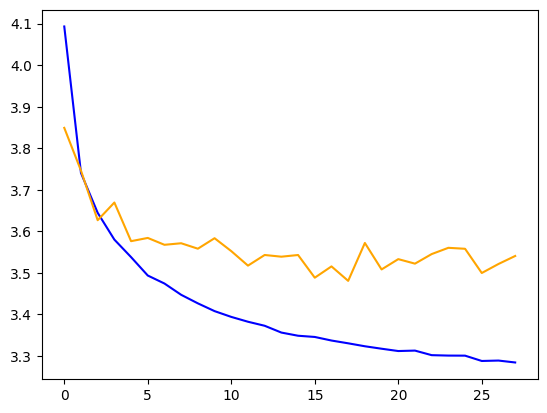

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

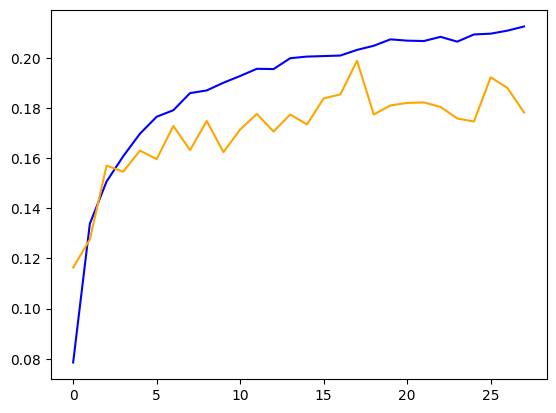

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

In [ ]:
predictions = model.predict(x_test).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [ ]:
df = pd.DataFrame(predictions, columns=["Label"])

In [ ]:
df

,Label
0,12
1,80
2,76
3,40
4,54
...,...
9995,80
9996,75
9997,33
9998,43


In [ ]:
df.index.name = "Id"

In [ ]:
df.to_csv("submission.csv")

# Prueba 2

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,182,100 (15.95 MB)

 Trainable params: 4,178,100 (15.94 MB)

 Non-trainable params: 4,000 (15.62 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 7,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=32,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1047 - loss: 4.0743
Epoch 1: val_accuracy improved from -inf to 0.12120, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 115s 80ms/step - accuracy: 0.1047 - loss: 4.0741 - val_accuracy: 0.1212 - val_loss: 3.8859 - learning_rate: 0.0010
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2005 - loss: 3.3472
Epoch 2: val_accuracy improved from 0.12120 to 0.17580, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 148s 84ms/step - accuracy: 0.2005 - loss: 3.3472 - val_accuracy: 0.1758 - val_loss: 3.5106 - learning_rate: 0.0010
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2522 - loss: 3.0519
Epoch 3: val_accuracy improved from 0.17580 to 0.19000, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 137s 81ms/step - accuracy: 0.2522 - loss: 3.0519 - val_accuracy: 0.1900 - val_loss: 3.4333 - learning_rate: 0.0010
Epoch 4/30

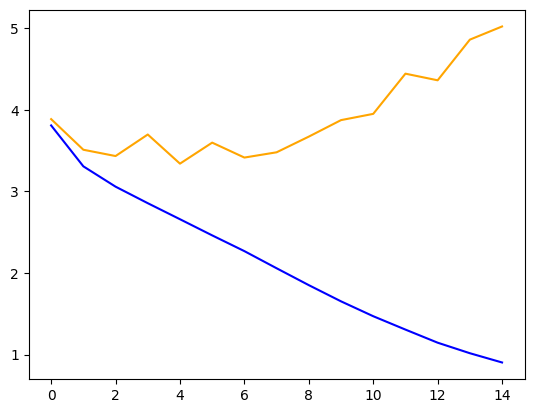

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

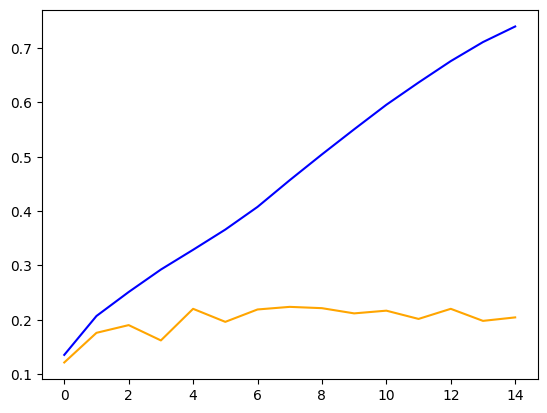

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

# Prueba 3

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,182,100 (15.95 MB)

 Trainable params: 4,178,100 (15.94 MB)

 Non-trainable params: 4,000 (15.62 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 7,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=32,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1025 - loss: 4.1035
Epoch 1: val_accuracy improved from -inf to 0.11760, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 71ms/step - accuracy: 0.1025 - loss: 4.1033 - val_accuracy: 0.1176 - val_loss: 3.9634 - learning_rate: 0.0010
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2020 - loss: 3.3488
Epoch 2: val_accuracy improved from 0.11760 to 0.19160, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 138s 68ms/step - accuracy: 0.2020 - loss: 3.3488 - val_accuracy: 0.1916 - val_loss: 3.4600 - learning_rate: 0.0010
Epoch 3/30
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2534 - loss: 3.0538
Epoch 3: val_accuracy did not improve from 0.19160
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 146s 71ms/step - accuracy: 0.2534 - loss: 3.0539 - val_accuracy: 0.1758 - val_loss: 3.4676 - learning_rate: 0.0010
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 

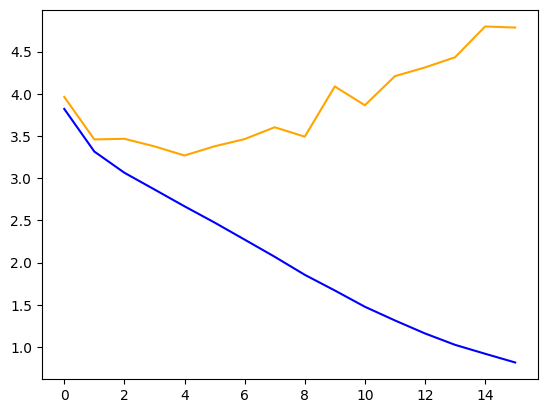

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

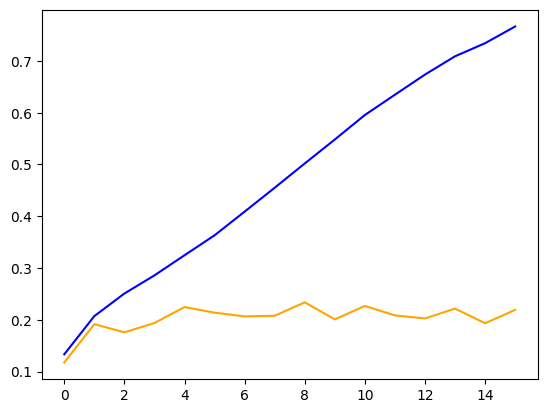

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

# Prueba 4

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,192,100 (23.62 MB)

 Trainable params: 6,184,100 (23.59 MB)

 Non-trainable params: 8,000 (31.25 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=16,
    epochs=30,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0678 - loss: 4.3531
Epoch 1: val_accuracy improved from -inf to 0.13720, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0679 - loss: 4.3530 - val_accuracy: 0.1372 - val_loss: 3.6812 - learning_rate: 0.0010
Epoch 2/30
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1387 - loss: 3.6701
Epoch 2: val_accuracy improved from 0.13720 to 0.16080, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1387 - loss: 3.6700 - val_accuracy: 0.1608 - val_loss: 3.5994 - learning_rate: 0.0010
Epoch 3/30
2811/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1727 - loss: 3.4690
Epoch 3: val_accuracy improved from 0.16080 to 0.18840, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.1727 - loss: 3.4690 - val_accuracy: 0.1884 - val_loss: 3.3943 - learning_rate: 0.0010
Epoch 4/30
2807/281

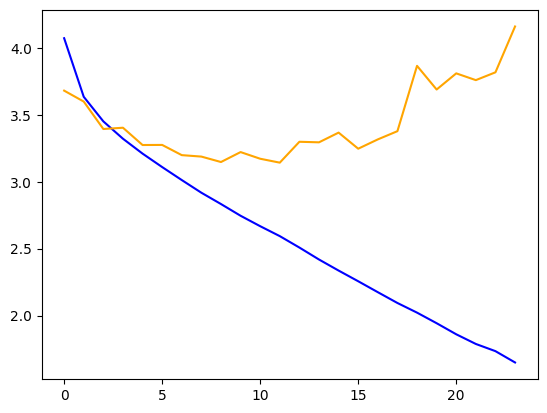

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

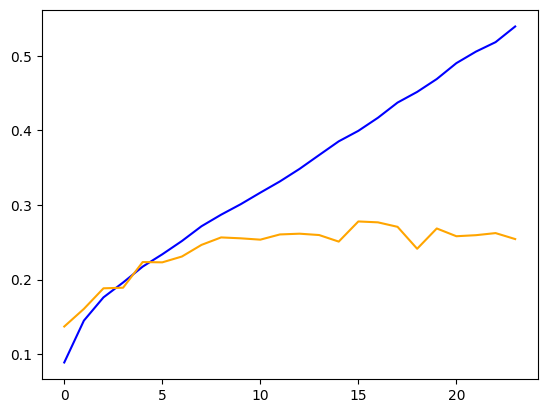

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

# Prueba 5

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000), max_norm(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,192,100 (23.62 MB)

 Trainable params: 6,184,100 (23.59 MB)

 Non-trainable params: 8,000 (31.25 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 12,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=8,
    epochs=100,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/100
5621/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0484 - loss: 4.5537
Epoch 1: val_accuracy improved from -inf to 0.12480, saving model to best_weights.weights.h5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.0485 - loss: 4.5534 - val_accuracy: 0.1248 - val_loss: 3.8051 - learning_rate: 0.0010
Epoch 2/100
5618/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1066 - loss: 3.8780
Epoch 2: val_accuracy improved from 0.12480 to 0.13680, saving model to best_weights.weights.h5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.1066 - loss: 3.8779 - val_accuracy: 0.1368 - val_loss: 3.7414 - learning_rate: 0.0010
Epoch 3/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1320 - loss: 3.7096
Epoch 3: val_accuracy improved from 0.13680 to 0.17200, saving model to best_weights.weights.h5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.1320 - loss: 3.7096 - val_accuracy: 0.1720 - val_loss: 3.5875 - learning_rate: 0.0010
Epoch 4/100
5612

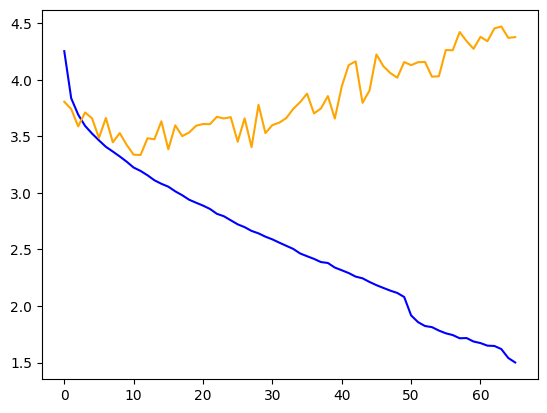

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

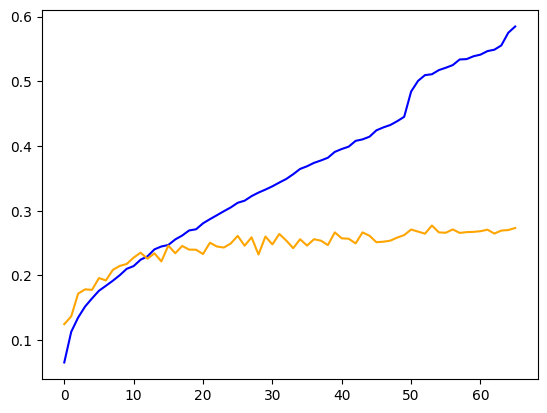

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

# Prueba 6 (mejor modelo encontrado)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,192,100 (23.62 MB)

 Trainable params: 6,184,100 (23.59 MB)

 Non-trainable params: 8,000 (31.25 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 8,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 12,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=16,
    epochs=100,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0706 - loss: 4.3349
Epoch 1: val_accuracy improved from -inf to 0.13020, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.0707 - loss: 4.3348 - val_accuracy: 0.1302 - val_loss: 3.8265 - learning_rate: 0.0010
Epoch 2/100
2805/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1385 - loss: 3.6730
Epoch 2: val_accuracy improved from 0.13020 to 0.14860, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1385 - loss: 3.6728 - val_accuracy: 0.1486 - val_loss: 3.6232 - learning_rate: 0.0010
Epoch 3/100
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1737 - loss: 3.4511
Epoch 3: val_accuracy improved from 0.14860 to 0.16440, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1737 - loss: 3.4511 - val_accuracy: 0.1644 - val_loss: 3.5417 - learning_rate: 0.0010
Epoch 4/100
2800

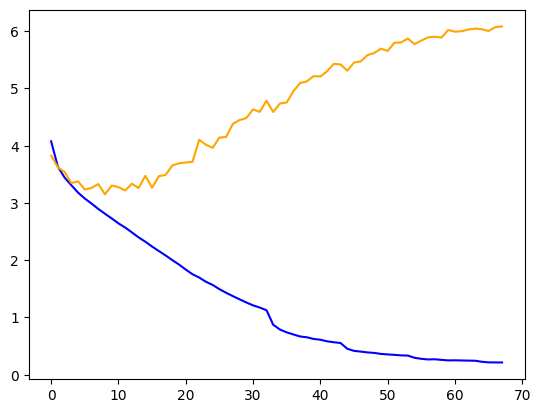

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

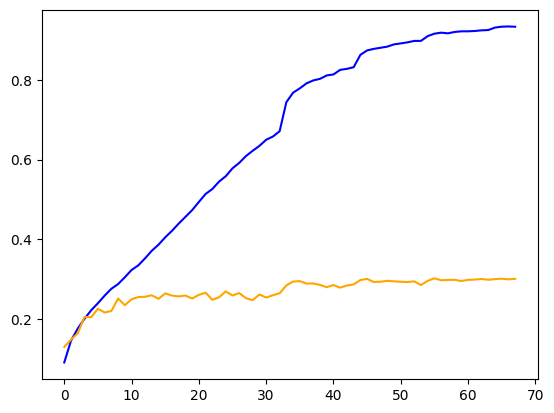

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

In [ ]:
predictions = model.predict(x_test).argmax(axis=1)
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"

df

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Label
Id,
0,8
1,8
2,27
3,10
4,71
...,...
9995,83
9996,6
9997,18


In [ ]:
df.to_csv("submission.csv")

# Prueba 7

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.0005))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,192,100 (23.62 MB)

 Trainable params: 6,184,100 (23.59 MB)

 Non-trainable params: 8,000 (31.25 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 10,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 12,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=16,
    epochs=100,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0810 - loss: 4.2000
Epoch 1: val_accuracy improved from -inf to 0.13500, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.0810 - loss: 4.2000 - val_accuracy: 0.1350 - val_loss: 3.8131 - learning_rate: 5.0000e-04
Epoch 2/100
2799/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1516 - loss: 3.6206
Epoch 2: val_accuracy improved from 0.13500 to 0.14100, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1516 - loss: 3.6204 - val_accuracy: 0.1410 - val_loss: 3.7935 - learning_rate: 5.0000e-04
Epoch 3/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1874 - loss: 3.3985
Epoch 3: val_accuracy improved from 0.14100 to 0.20280, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1874 - loss: 3.3984 - val_accuracy: 0.2028 - val_loss: 3.4126 - learning_rate: 5.0000e-04
Epoc

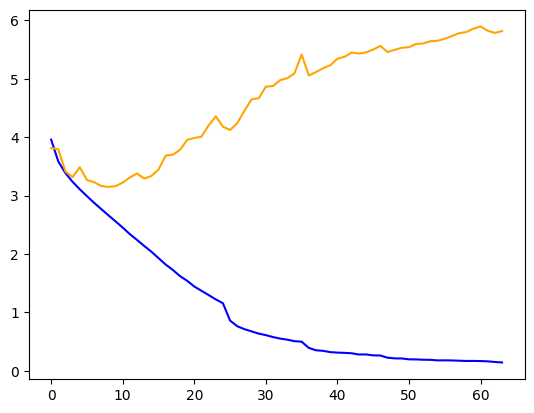

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

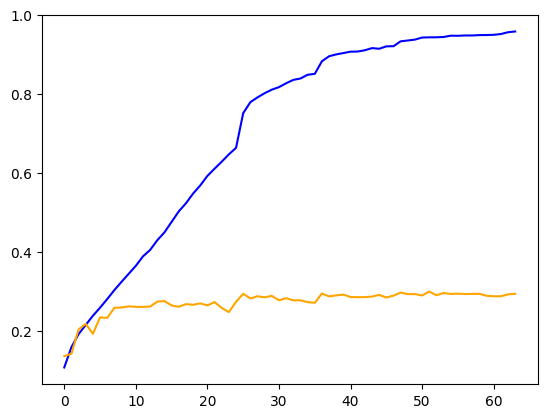

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

# Prueba 8

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1000, activation="relu", kernel_constraint = max_norm(10)))
model.add(Dropout(0.2))
model.add(Dense(1000, activation="relu", kernel_constraint = max_norm(10)))
model.add(Dropout(0.2))
model.add(Dense(1000, activation="relu", kernel_constraint = max_norm(10)))
model.add(Dropout(0.2))
model.add(Dense(1000, activation="relu", kernel_constraint = max_norm(10)))
model.add(Dropout(0.2))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │       3,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         100,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,176,100 (23.56 MB)

 Trainable params: 6,176,100 (23.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 8,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 12,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=16,
    epochs=100,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0110 - loss: 4.6349
Epoch 1: val_accuracy improved from -inf to 0.01000, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0110 - loss: 4.6349 - val_accuracy: 0.0100 - val_loss: 4.6058 - learning_rate: 0.0010
Epoch 2/100
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0097 - loss: 4.6068
Epoch 2: val_accuracy did not improve from 0.01000
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0097 - loss: 4.6068 - val_accuracy: 0.0100 - val_loss: 4.6053 - learning_rate: 0.0010
Epoch 3/100
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0101 - loss: 4.6061
Epoch 3: val_accuracy did not improve from 0.01000
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.0101 - loss: 4.6061 - val_accuracy: 0.0100 - val_loss: 4.6055 - learning_rate: 0.0010
Epoch 4/100
2800/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0098 - loss: 4.6063
Epoch 4: val_accu

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

In [ ]:
predictions = model.predict(x_test).argmax(axis=1)
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"

df

In [ ]:
df.to_csv("submission.csv")

# Prueba 9

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(800))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(800))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(800))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(800))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 800)                 │       2,458,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 800)                 │           3,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 800)                 │         640,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 800)                 │           3,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 800)                 │         640,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 800)                 │           3,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 800)                 │         640,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 800)                 │           3,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          80,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,473,700 (17.07 MB)

 Trainable params: 4,467,300 (17.04 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 8,
    verbose = 1,
    min_lr = 1e-5
)

In [ ]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 12,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
history = model.fit(
    x = x_train,
    y= y_train,
    batch_size=16,
    epochs=100,
    validation_data = (x_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0723 - loss: 4.2650
Epoch 1: val_accuracy improved from -inf to 0.12660, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.0723 - loss: 4.2649 - val_accuracy: 0.1266 - val_loss: 3.8308 - learning_rate: 0.0010
Epoch 2/100
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1447 - loss: 3.6514
Epoch 2: val_accuracy improved from 0.12660 to 0.13380, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.1447 - loss: 3.6512 - val_accuracy: 0.1338 - val_loss: 3.6924 - learning_rate: 0.0010
Epoch 3/100
2804/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1750 - loss: 3.4466
Epoch 3: val_accuracy improved from 0.13380 to 0.18220, saving model to best_weights.weights.h5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1750 - loss: 3.4466 - val_accuracy: 0.1822 - val_loss: 3.4096 - learning_rate: 0.0010
Epoch 4/100
2799

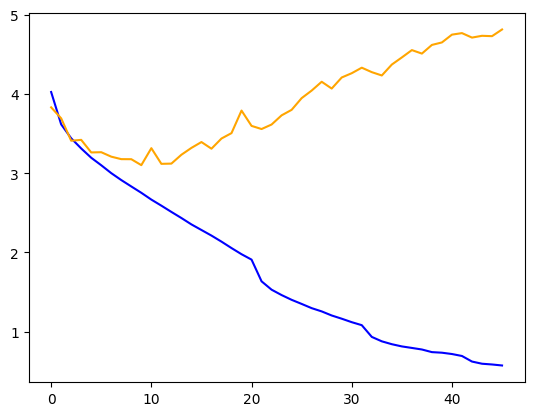

In [ ]:
plt.plot(history.history["loss"], color = 'blue')
plt.plot(history.history["val_loss"], color = 'orange')

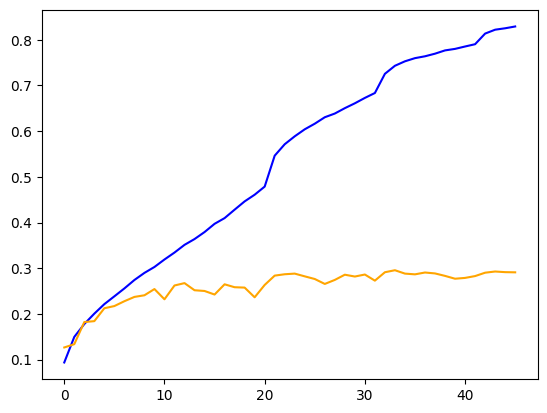

In [ ]:
plt.plot(history.history["accuracy"], color = 'blue')
plt.plot(history.history["val_accuracy"], color = 'orange')

In [ ]:
predictions = model.predict(x_test).argmax(axis=1)
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"

df

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Label
Id,
0,8
1,8
2,27
3,10
4,71
...,...
9995,83
9996,6
9997,18


In [ ]:
df.to_csv("submission.csv")